In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
!pip install keras-tuner --upgrade

## Importing Required Libraries

In [212]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [213]:
from tensorflow.keras.callbacks import Callback

In [214]:
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

In [215]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Importing DataSet

In [216]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')

data = pd.DataFrame(data)

In [217]:
data.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,k
0,376.228731,376.105858,375.982985,375.860112,375.737238,375.614365,375.491492,375.368619,375.245746,375.122873,375,162.769570
1,378.621190,378.259071,377.896952,377.534833,377.172714,376.810595,376.448476,376.086357,375.724238,375.362119,375,55.230459
2,376.947473,376.752726,376.557978,376.363231,376.168484,375.973736,375.778989,375.584242,375.389495,375.194747,375,102.697189
3,376.348463,376.213616,376.078770,375.943924,375.809078,375.674231,375.539385,375.404539,375.269693,375.134846,375,148.317051
4,377.804453,377.524008,377.243562,376.963117,376.682672,376.402226,376.121781,375.841336,375.560891,375.280445,375,71.315157


In [218]:
original_data_x = data.iloc[:,:11]
original_data_x.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2
0,376.228731,376.105858,375.982985,375.860112,375.737238,375.614365,375.491492,375.368619,375.245746,375.122873,375
1,378.621190,378.259071,377.896952,377.534833,377.172714,376.810595,376.448476,376.086357,375.724238,375.362119,375
2,376.947473,376.752726,376.557978,376.363231,376.168484,375.973736,375.778989,375.584242,375.389495,375.194747,375
3,376.348463,376.213616,376.078770,375.943924,375.809078,375.674231,375.539385,375.404539,375.269693,375.134846,375
4,377.804453,377.524008,377.243562,376.963117,376.682672,376.402226,376.121781,375.841336,375.560891,375.280445,375


In [219]:
# Define the standard deviation of the noise
noise_stddev = 0.05  # Adjust this value as needed

# Add random noise to the DataFrame
noise = np.random.normal(0, noise_stddev, size=original_data_x.shape)
original_data_x = original_data_x + noise

In [220]:
y = data.iloc[:,-1]
y.head()

0    162.769570
1     55.230459
2    102.697189
3    148.317051
4     71.315157
Name: k, dtype: float64

In [221]:
result = pd.concat([original_data_x, y], axis=1)
result.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,k
0,376.212182,376.146412,376.073824,375.911064,375.704433,375.567259,375.465073,375.351743,375.201075,375.101880,374.956612,162.769570
1,378.570211,378.212595,377.846440,377.457976,377.168870,376.732042,376.484458,376.039027,375.713151,375.328626,374.916381,55.230459
2,376.936173,376.732353,376.514248,376.399541,376.230080,376.052980,375.742509,375.606677,375.393544,375.143565,374.984528,102.697189
3,376.288257,376.113597,376.107511,375.850843,375.743657,375.632251,375.436894,375.420943,375.227800,375.160421,375.019350,148.317051
4,377.730910,377.552652,377.302104,376.924559,376.542269,376.475858,376.206323,375.790254,375.627330,375.233625,374.971215,71.315157


In [121]:
# from sklearn.preprocessing import StandardScaler
# #Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the DataFrame and create a new DataFrame
# result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

In [222]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the DataFrame and create a new DataFrame
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

print("\nNormalized DataFrame:")
print(result)


Normalized DataFrame:
            0      0.02      0.04      0.06      0.08       0.1      0.12  \
0    0.014733  0.020066  0.023613  0.024682  0.016794  0.017406  0.020155   
1    0.142746  0.144441  0.144013  0.144818  0.147917  0.143172  0.157563   
2    0.054038  0.055337  0.053528  0.062618  0.063859  0.069851  0.057552   
3    0.018863  0.018090  0.025901  0.020005  0.020306  0.024424  0.016356   
4    0.097182  0.104715  0.107041  0.103392  0.091812  0.115511  0.120072   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.012763  0.015728  0.013663  0.020636  0.009807  0.025232  0.015385   
996  0.009426  0.012932  0.014731  0.010430  0.010501  0.006223  0.013894   
997  0.075681  0.084752  0.086941  0.084051  0.083849  0.083896  0.093074   
998  0.022676  0.025765  0.025404  0.035955  0.029290  0.037117  0.028126   
999  0.012262  0.018898  0.017551  0.021703  0.019423  0.019621  0.021619   

         0.14      0.16      0.18       0.2         

In [223]:
result = result.sample(frac=1.0, random_state=100)  # Set a random_state for reproducibility

In [224]:
x_train = result.iloc[:900,:-1]
x_test = result.iloc[900:,:-1]
x_train.shape, x_test.shape

((900, 11), (100, 11))

In [225]:
y_train = result.iloc[:900,-1]
y_test = result.iloc[900:,-1]
y_train.shape, y_test.shape

((900,), (100,))

In [226]:
# Load Toy Example Data
training_feature = x_train
ground_truth_k = y_train

testing_feature_sk = x_test
testing_score = y_test

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [227]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_k = (1, )

intermediate_dim_1 = 8
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 1
latent_dim = 1
epochs = 100 # max number of epochs

# VAE model = encoder + decoder
# build encoder model

inputs_x = Input(shape=input_shape_x, name='temp_input')
inputs_k = Input(shape=input_shape_k, name='ground_truth')

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,inputs_k], [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_3, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(inter_y1)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim, activation = 'linear')(inter_y3)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder([inputs_x,inputs_k])[2])
vae = Model([inputs_x,inputs_k], [outputs], name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temp_input (InputLayer)     [(None, 11)]                 0         []                            
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    96        ['temp_input[0][0]']          
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1[0][0]
 nse)                                                               ']                            
                                                                                            

## Loss Function

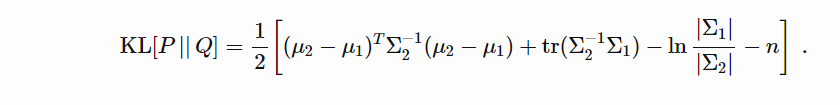

In [228]:
def kl_divergence_multivariate_normal_keras(mu_p, log_var_p, mu_q, log_var_q):
    sigma_p = K.exp(log_var_p)            ## log variance to variance
    sigma_q = K.exp(log_var_q)

    term1 = K.sum(sigma_p / sigma_q)
    term2 = K.sum(K.square(mu_q - mu_p) / sigma_q)
    term3 = -1
    term4 = K.sum(log_var_q - log_var_p)

    return 0.5 * (term1 + term2 + term3 + term4)

In [129]:
import tensorflow as tf
import numpy as np

# Define x_values as a sequence from 0 to 0.2 with a spacing of 0.02
x_values = np.linspace(0, 0.2, 11, dtype=np.float32)

# Ensure x_values is a TensorFlow tensor for compatibility with GradientTape operations
x_values_tensor = tf.convert_to_tensor(x_values, dtype=tf.float32)

In [179]:
def compute_second_derivative(outputs, x_values):
    with tf.GradientTape() as tape2:
        tape2.watch(x_values)
        with tf.GradientTape() as tape1:
            tape1.watch(x_values)
            T_pred = outputs
        dT_dx = tape1.gradient(T_pred, x_values)
    d2T_dx2 = tape2.gradient(dT_dx, x_values)
    return d2T_dx2

def compute_pinn_loss(outputs, x_values):
    d2T_dx2 = compute_second_derivative(outputs, x_values)
    pinn_loss = tf.reduce_mean(tf.square(d2T_dx2))
    return pinn_loss

In [180]:
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy.linalg import det, inv

##Customize Lost Function of the VAE Model
models = (encoder, decoder)

reconstruction_loss = mse(inputs_x,outputs)
reconstruction_loss = K.abs(reconstruction_loss)


kl_loss = kl_divergence_multivariate_normal_keras(inputs_k, K.constant([0.0]), z_mean, z_log_var)

label_loss = kl_divergence_multivariate_normal_keras(z_mean, z_log_var, inputs_k, K.constant([0.0]))

# pinn_loss = compute_pinn_loss(outputs, x_values_tensor)
vae_loss = K.mean(reconstruction_loss + kl_loss + label_loss)

vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.01)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)
vae.summary()
vae.save_weights('random_weights.h5')

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temp_input (InputLayer)     [(None, 11)]                 0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 1),                  167       ['temp_input[0][0]',          
                              (None, 1),                             'ground_truth[0][0]']        
                              (None, 1)]                                                          
                                                                                            

In [132]:
# import tensorflow as tf

# # Example function for demonstration purposes
# def compute_inputs_k(x):
#     # Assuming inputs_k is some function of x; replace with your actual computation
#     return x ** 2 + 3 * x + 5

# # Placeholder for x; replace with your actual tensor
# x = tf.Variable(1.0, dtype=tf.float32)
# print(x)
# with tf.GradientTape() as tape2:
#     tape2.watch(x)
#     with tf.GradientTape() as tape1:
#         tape1.watch(x)
#         inputs_k = compute_inputs_k(x)
#     # First derivative of inputs_k with respect to x
#     first_derivative = tape1.gradient(inputs_k, x)
# # Second derivative of inputs_k with respect to x
# second_derivative = tape2.gradient(first_derivative, x)

# print("First derivative:", first_derivative.numpy())
# print("Second derivative:", second_derivative.numpy())

# Stop when validation loss does not improves

Epoch 1/100
884/900 [============================>.] - ETA: 0s - loss: 0.0466

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


900/900 [==============================] - 5s 3ms/step - loss: 0.0465 - val_loss: 0.0185
Epoch 2/100
892/900 [============================>.] - ETA: 0s - loss: 0.0305

900/900 [==============================] - 4s 4ms/step - loss: 0.0303 - val_loss: 0.0167
Epoch 3/100
889/900 [============================>.] - ETA: 0s - loss: 0.0313

900/900 [==============================] - 7s 7ms/step - loss: 0.0310 - val_loss: 0.0162
Epoch 4/100
889/900 [============================>.] - ETA: 0s - loss: 0.0305

900/900 [==============================] - 5s 5ms/step - loss: 0.0302 - val_loss: 0.0145
Epoch 5/100
900/900 [==============================] - 5s 6ms/step - loss: 0.0304 - val_loss: 0.0171
Epoch 6/100
900/900 [==============================] - 8s 9ms/step - loss: 0.0305 - val_loss: 0.0189
Epoch 7/100
900/900 [==============================] - 9s 10ms/step - loss: 0.0304 - val_loss: 0.0166
Epoch 8/100
900/900 [==============================] - 7s 8ms/step - loss: 0.0301 - val_loss: 0.0184
Epoch 9/100
900/900 [==============================] - 9s 10ms/step - loss: 0.0302 - val_loss: 0.0147
Epoch 9: early stopping


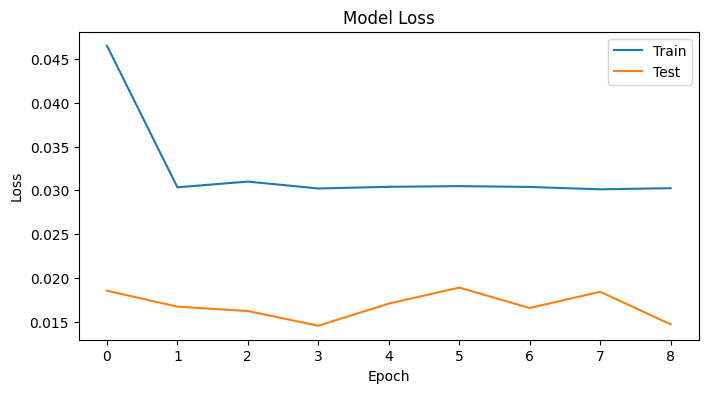

In [181]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model with validation data and callbacks
history = vae.fit([x_train, y_train],x_train,
                  epochs=100,
                  batch_size=batch_size,
                  validation_data=([x_test, y_test], x_test),
                  callbacks=[early_stopping, model_checkpoint])

# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [134]:
[z_mean, z_log_var, z] = encoder.predict([x_train,y_train],batch_size=batch_size)

900/900 [==============================] - 1s 1ms/step


Mean squared error: 0.001
R2 Variance score: 0.986


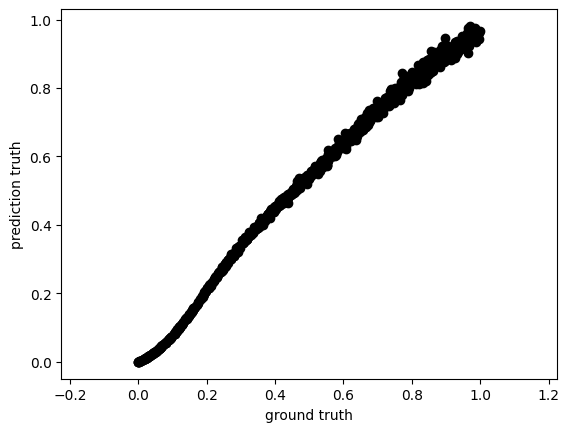

In [135]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_train, z_mean))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_train, z_mean))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_train, z_mean,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [136]:
[z_mean_t, z_log_var_t, z_t] = encoder.predict([x_test,y_test],batch_size=batch_size)

100/100 [==============================] - 0s 1ms/step


Mean squared error: 0.001
R2 Variance score: 0.982


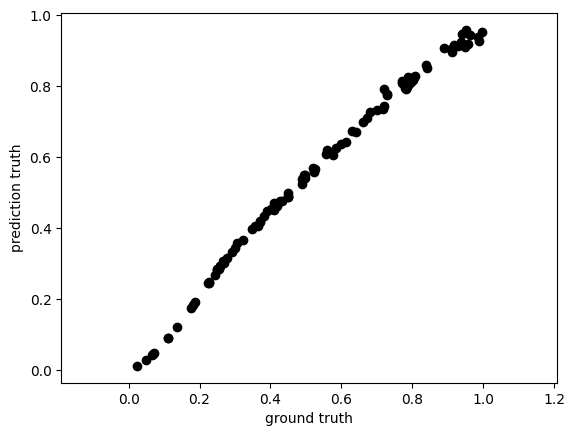

In [137]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, z_mean_t))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_test, z_mean_t))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_test, z_mean_t,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [138]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

# # Assuming 'result' is your DataFrame containing the data

# # Define the number of splits (folds) for cross-validation
# num_splits = 5  # You can adjust this as needed

# # Initialize KFold cross-validation splitter
# kf = KFold(n_splits=num_splits, shuffle=True, random_state=11)

# # Initialize lists to store RMSE and R2 scores
# rmse_scores = []
# r2_scores = []

# # Iterate over the splits
# for train_idx, test_idx in kf.split(result):
#     # Split the data into training and testing sets for this fold
#     train_data = result.iloc[train_idx]
#     test_data = result.iloc[test_idx]

#     x_train = train_data.iloc[:, :-1]
#     y_train = train_data.iloc[:, -1]

#     x_test = test_data.iloc[:, :-1]
#     y_test = test_data.iloc[:, -1]

#     # Train the VAE model (assuming 'vae' is already defined)
#     history = vae.fit([x_train, y_train], epochs=epochs, batch_size=batch_size, verbose=0)

#     # Predict and evaluate on the training set
#     [z_mean, z_log_var, z] = encoder.predict([x_train, y_train], batch_size=batch_size)
#     rmse_train = np.sqrt(mean_squared_error(y_train, z_mean))
#     r2_train = r2_score(y_train, z_mean)

#     # Predict and evaluate on the test set
#     [z_mean_t, z_log_var_t, z_t] = encoder.predict([x_test, y_test], batch_size=batch_size)
#     rmse_test = np.sqrt(mean_squared_error(y_test, z_mean_t))
#     r2_test = r2_score(y_test, z_mean_t)

#     # Append RMSE and R2 scores for this fold
#     rmse_scores.append(rmse_test)
#     r2_scores.append(r2_test)

# # Calculate the average RMSE and R2 scores across all folds
# average_rmse = np.mean(rmse_scores)
# average_r2 = np.mean(r2_scores)

# print(f'Average RMSE: {average_rmse}')
# print(f'Average R2 score: {average_r2}')

In [139]:
x_test

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2
907,0.031855,0.035006,0.030534,0.044965,0.036655,0.034800,0.036515,0.046048,0.059886,0.105952,0.642419
495,0.027245,0.021605,0.022085,0.016700,0.017454,0.028396,0.023381,0.036550,0.047304,0.090956,0.473555
502,0.019633,0.021002,0.017767,0.015642,0.028634,0.016255,0.025658,0.036402,0.040339,0.038499,0.341984
215,0.045795,0.052149,0.049368,0.045129,0.061219,0.052334,0.058388,0.065510,0.064908,0.124194,0.611333
394,0.087793,0.091911,0.086724,0.085696,0.096634,0.087129,0.094825,0.084274,0.102347,0.129613,0.752692
...,...,...,...,...,...,...,...,...,...,...,...
855,0.035607,0.037243,0.036041,0.033248,0.027852,0.032364,0.049501,0.052384,0.083486,0.123744,0.395393
871,0.019407,0.022259,0.021202,0.017911,0.023083,0.022430,0.022817,0.030333,0.059441,0.082748,0.722055
835,0.092048,0.092033,0.091004,0.086667,0.090654,0.098082,0.105181,0.094359,0.107943,0.143332,0.385213
792,0.031469,0.017729,0.027535,0.027393,0.034221,0.032126,0.039849,0.028944,0.055968,0.068297,0.482583


In [140]:
y_test

907    0.642572
495    0.783557
502    0.804018
215    0.525069
394    0.364524
         ...   
855    0.629121
871    0.784068
835    0.356928
792    0.718202
520    0.136600
Name: k, Length: 100, dtype: float64

In [141]:
# train original data
y_train_np = y_train.to_numpy().reshape(-1, 1)
concatenated_data_train = np.concatenate((x_train, y_train_np), axis=1)
original_data_restored_train = scaler.inverse_transform(concatenated_data_train)
original_data_restored_train.shape

(900, 12)

In [142]:
# test original data
y_test_np = y_test.to_numpy().reshape(-1, 1)
concatenated_data_test = np.concatenate((x_test, y_test_np), axis=1)
original_data_restored_test = scaler.inverse_transform(concatenated_data_test)
original_data_restored_test.shape

(100, 12)

In [143]:
# Use the decoder to generate predictions
predictions_train = decoder.predict(z)
predictions_test = decoder.predict(z_t)

4/4 [==============================] - 0s 3ms/step


In [144]:
# train decoded data
decoded_data_train = np.concatenate((predictions_train, z_mean), axis=1)
decoded_data_train_rescaled = scaler.inverse_transform(decoded_data_train)
decoded_data_train_rescaled.shape

(900, 12)

In [145]:
# train decoded data
decoded_data_test = np.concatenate((predictions_test, z_mean_t), axis=1)
decoded_data_test_rescaled = scaler.inverse_transform(decoded_data_test)
decoded_data_test_rescaled.shape

(100, 12)

Mean squared error: 41.275
R2 Variance score: 0.986


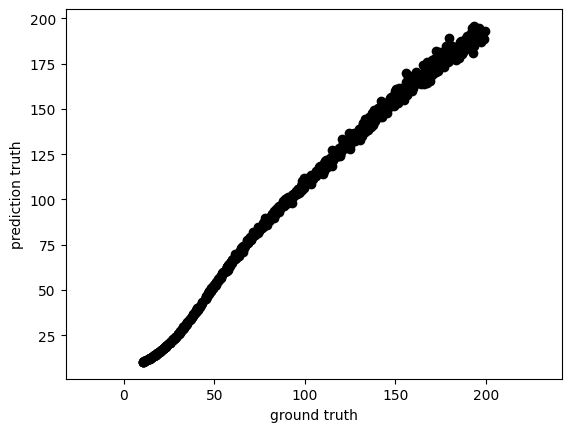

In [146]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1],  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

Mean squared error: 47.347
R2 Variance score: 0.982


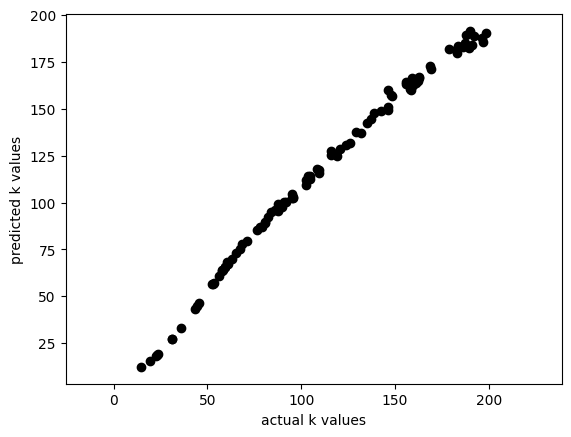

In [147]:
## Test Data
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1],  color='black')
plt.xlabel('actual k values')
plt.ylabel('predicted k values')
ax.axis('equal');

900/900 [==============================] - 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(-0.39250097604229345,
 0.19084298450639733,
 -0.15951012224810485,
 0.068594360382602)

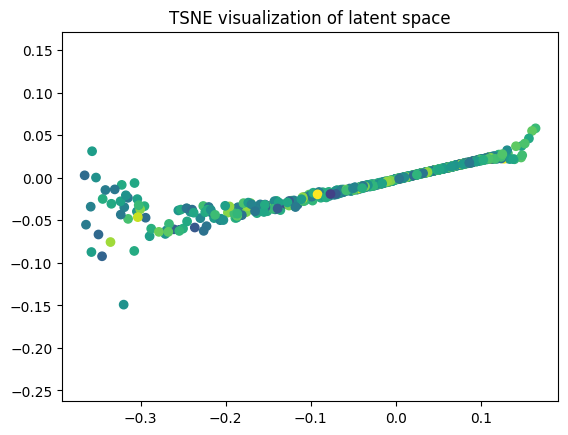

In [148]:
## Visualize Latent Space
vae.load_weights('random_weights.h5')
# vae.fit([training_feature,ground_truth_r],
#          epochs=epochs,
#          batch_size=batch_size,
#          verbose = 0)

[z_mean, z_log_var, z] = encoder.predict([x_train,y_train],batch_size=batch_size)

tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c= z)
plt.title('TSNE visualization of latent space')
ax.axis('equal')

In [149]:
std_deviation_z_t = np.sqrt(np.exp(z_log_var_t))
std_deviation_z_t[:5]

array([[1.0010484 ],
       [1.0031532 ],
       [1.0037267 ],
       [0.9992543 ],
       [0.99675035]], dtype=float32)

## Bayesian Results

162.70020036535794
0.18077766863406217


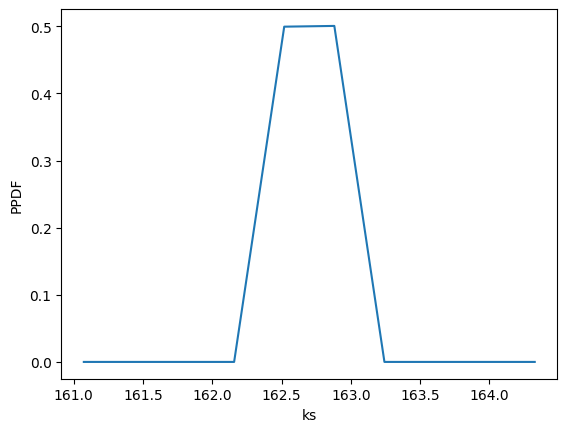

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Problem Parameters
q = 1000
L = 0.2
TL = 375
sig_m = 0.05
x = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2])
T = np.array([376.228731, 376.105858,	375.982985,	375.860112,	375.737238,	375.614365,	375.491492,	375.368619,	375.245746,	375.122873,	375])
Nm = len(x)

# Priors
mu_k = 162.7
sigma_k = 0.01 * mu_k

kmin = mu_k - sigma_k
kmax = mu_k + sigma_k
Ns = 10
ks = np.linspace(kmin, kmax, Ns)

Tsim = np.zeros((Ns, Nm))
P1 = np.zeros(Ns)
P2 = np.zeros(Ns)
P3a = np.zeros(Ns)

for i in range(Ns):
    Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
    e = Tsim[i, :] - T
    A = np.sum(e**2)
    B = (ks[i] - mu_k)**2 / sigma_k**2
    S = A + B
    f = -0.5 * S / sig_m**2
    P1[i] = np.exp(f)
    P2[i] = ks[i] * P1[i]
    P3a[i] = ks[i]**2 * P1[i]
Den = np.sum(P1)
PPDF = P1 / Den
km = np.sum(P2) / Den
print(km)
vark = np.sum(P3a) / Den - km**2
sq = np.sqrt(vark)
print(sq)
# Plot the data
plt.plot(ks, PPDF, '-')
plt.xlabel('ks')
plt.ylabel('PPDF')
plt.show()

In [151]:
import numpy as np

# Define an array of different k values
k_values = original_data_restored_test[:,-1]

# Define a 2D array of different T values
T_values_2d = original_data_restored_test[:,:-1]
# Initialize lists to store km and sq values for each set
km_list = []
sq_list = []

# Problem Parameters
q = 1000
L = 0.2
TL = 375
sig_m = 0.05
x = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2])
Nm = len(x)

# Priors
Ns = 10

for k, T_values in zip(k_values, T_values_2d):
        sigma_k = 0.01 * k
        kmin = k - sigma_k
        kmax = k + sigma_k
        ks = np.linspace(kmin, kmax, Ns)

        Tsim = np.zeros((Ns, Nm))
        P1 = np.zeros(Ns)
        P2 = np.zeros(Ns)
        P3a = np.zeros(Ns)

        for i in range(Ns):
            Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
            e = Tsim[i, :] - T_values
            A = np.sum(e**2)
            B = (ks[i] - k)**2 / sigma_k**2
            S = A + B
            f = -0.5 * S / sig_m**2
            P1[i] = np.exp(f)
            P2[i] = ks[i] * np.exp(f)
            P3a[i] = ks[i]**2 * np.exp(f)

        Den = np.sum(P1)
        km = np.sum(P2) / Den
        vark = np.sum(P3a) / Den - km**2
        sq = np.sqrt(vark)

        # Store km and sq values in the lists
        km_list.append(km)
        sq_list.append(sq)

# km_list and sq_list now contain the results for each set of T values and the associated k value
# You will have km and sq values for each combination of T values and k value
for km, sq in zip(km_list, sq_list):
    print(f"km: {km}, sq: {sq}")

km: 131.78664740763793, sq: 0.1463806961632593
km: 158.4188060134052, sq: 0.17534920937004655
km: 162.2938989958128, sq: 0.18018813126450264
km: 109.59065019633216, sq: 0.12161784159044929
km: 79.24582847416809, sq: 0.08804003739332597
km: 14.59900212296626, sq: 0.016081852304500186
km: 191.29553342176158, sq: 0.21233372045622587
km: 187.5653444120968, sq: 0.20839658723540933
km: 53.05462295290006, sq: 0.05806332492163845
km: 22.58982270172851, sq: 0.023108673817614167
km: 178.53639440104047, sq: 0.19819740368142785
km: 148.1981321015789, sq: 0.1643694732952314
km: 23.35098040831015, sq: 0.025315098969307375
km: 102.70937708973173, sq: 0.11354026346912623
km: 162.77504062139187, sq: 0.1807723307013535
km: 116.06861853007236, sq: 0.12853958819191172
km: 161.07788980683327, sq: 0.17885355199750433
km: 196.4959475352054, sq: 0.2183036493568039
km: 104.57814170636024, sq: 0.11601866478984767
km: 192.2586045997729, sq: 0.21360570425072656
km: 198.68821326641162, sq: 0.22076394896092436
km: 

Mean squared error: 47.311
R2 Variance score: 0.982


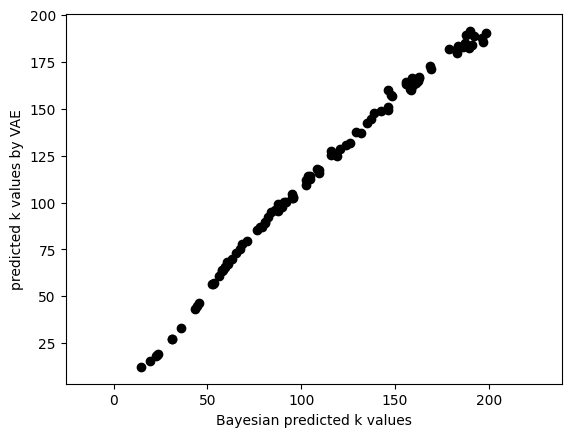

In [152]:
## Test Data
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(km_list, decoded_data_test_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(km_list, decoded_data_test_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(km_list, decoded_data_test_rescaled[:,-1],  color='black')
plt.xlabel('Bayesian predicted k values')
plt.ylabel('predicted k values by VAE')
ax.axis('equal');

## Hyperparameter Tuning for different losses

In [229]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

# Adding weights to different loss functions

class CustomVAE(Model):
    def __init__(self, encoder, decoder, weight_reconstruction=1.0, weight_kl=1.0, weight_label=1.0, **kwargs):
        super(CustomVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.weight_reconstruction = weight_reconstruction
        self.weight_kl = weight_kl
        self.weight_label = weight_label

    def call(self, inputs):
        inputs_x, inputs_k = inputs
        z_mean, z_log_var, z = self.encoder([inputs_x, inputs_k])
        reconstructed = self.decoder(z)
        self.add_loss(self.vae_loss(inputs_x, inputs_k, z_mean, z_log_var, reconstructed))
        return reconstructed

    def vae_loss(self, inputs_x, inputs_k, z_mean, z_log_var, reconstructed):
        reconstruction_loss = mse(inputs_x, reconstructed)
        reconstruction_loss *= self.weight_reconstruction

        kl_loss = kl_divergence_multivariate_normal_keras(inputs_k, K.constant([0.0]), z_mean, z_log_var)
        kl_loss *= self.weight_kl

        label_loss = kl_divergence_multivariate_normal_keras(z_mean, z_log_var, inputs_k, K.constant([0.0]))
        label_loss *= self.weight_label

        return K.mean(reconstruction_loss + kl_loss + label_loss)

In [238]:
from kerastuner import HyperParameters, RandomSearch

def build_vae(hp):


    weight_label = hp.Float('weight_label', min_value=0.1, max_value=1, step=0.1)
    weight_kl = hp.Float('weight_kl', min_value=0.1, max_value=1, step=0.1)
    weight_reconstruction = hp.Float('weight_reconstruction', min_value=0.1, max_value=1, step=0.1)

    total = weight_kl + weight_label + weight_reconstruction
    weight_reconstruction = weight_reconstruction / total
    weight_kl = weight_kl / total
    weight_label = weight_label / total
    vae = CustomVAE(encoder, decoder, weight_reconstruction, weight_kl, weight_label)
    optimizer = Adam(learning_rate=0.01)  # Consider tuning learning rate as well
    vae.compile(optimizer=optimizer)
    return vae

tuner = RandomSearch(
    build_vae,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='lostuning'
)

tuner.search([x_train, y_train], x_train,
             epochs=3,
             batch_size=batch_size,
             validation_data=([x_test, y_test], x_test))

Trial 5 Complete [00h 00m 10s]
val_loss: 0.00395831186324358

Best val_loss So Far: 0.0016904025105759501
Total elapsed time: 00h 01m 33s


In [242]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extract the best weights
best_weight_label = best_hps.get('weight_label')
best_weight_kl = best_hps.get('weight_kl')
best_weight_reconstruction = best_hps.get('weight_reconstruction')

# Normalize the weights to ensure their sum equals 1
total_best = best_weight_label + best_weight_kl + best_weight_reconstruction
best_weight_reconstruction /= total_best
best_weight_kl /= total_best
best_weight_label /= total_best

# Print the best weights
print(f"Best weight for label loss: {best_weight_label}")
print(f"Best weight for KL divergence: {best_weight_kl}")
print(f"Best weight for reconstruction loss: {best_weight_reconstruction}")

Best weight for label loss: 0.3333333333333333
Best weight for KL divergence: 0.6
Best weight for reconstruction loss: 0.06666666666666667


In [243]:
# Build the best model
best_model = build_vae(best_hps)

In [246]:
# Save the best model's weights
best_model.save_weights('best_model_weights.h5')

In [252]:
model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, mode='min', save_format='tf')
model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, mode='min')

Epoch 1/100
898/900 [============================>.] - ETA: 0s - loss: 0.0068

900/900 [==============================] - 5s 6ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 2/100
883/900 [============================>.] - ETA: 0s - loss: 0.0068

900/900 [==============================] - 4s 4ms/step - loss: 0.0067 - val_loss: 0.0014
Epoch 3/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 4/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 5/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 6/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0086 - val_loss: 0.0027
Epoch 7/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 7: early stopping


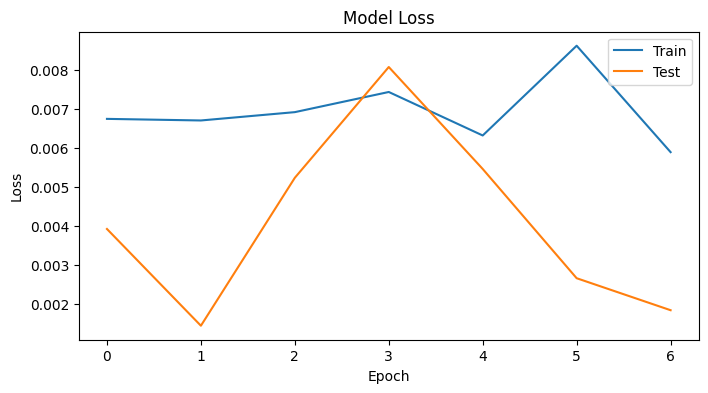

In [253]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, mode='min')

# Train the model with validation data and callbacks
history = best_model.fit([x_train, y_train], x_train,
                         epochs=100,
                         batch_size=batch_size,
                         validation_data=([x_test, y_test], x_test),
                         callbacks=[early_stopping, model_checkpoint])


# Plot training & validation loss values
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

How Early Stopping Works

During Training: As the model trains, it periodically checks the validation loss after each epoch.

Monitoring Performance: It keeps track of the minimum validation loss observed during training. After each epoch, it compares the current validation loss to the best loss observed so far.

Patience Counter: If the validation loss does not improve (decrease, in this case), a counter is incremented. If the validation loss improves, the counter is reset to 0.

Advantages of Early Stopping

Prevents Overfitting: By stopping training before the model begins to overfit to the training data, Early Stopping helps the model generalize better to unseen data.

Saves Time and Resources: It reduces unnecessary training time and computational resources by halting the training process once the model ceases to improve.